In [1]:
# importing necessary libraries
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# -------------------------
# Environment & traffic params
# -------------------------
T_p = 1             # time quantum (seconds)
L = 300             # bits/packet in queue
Q_max = 60          # threshold for high queue
Q_threshold = 40   # threshold for low queue
W_max = 300         # max bandwidth (units treated as service capacity per second)
cycles = 24         # number of cycles per episode (hours)
p_threshold_drop = 0.01  # packet drop probability threshold
p_threshold_vilotion = 0.1 # queue violation probability threshold
second_in_hour = 3600  # seconds per cycle (1 hour)
episodes = 1000     # reduce for faster runs; set to 1000 for full run
hours_in_day = 24   # hours in a day
W_levels = np.linspace(20, W_max, 25)  # 25 bandwidth choices (20, 40, ... , W_max=500)

[  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120. 132. 144. 156.
 168. 180. 192. 204. 216. 228. 240. 252. 264. 276. 288. 300.]


In [ ]:
# Load hourly mean arrival rates from CSV file, excluding the first column (assumed to be an index or timestamp)
# The resulting array has shape (episodes, cycles) for use in environment simulation
mean_arrival_rates = pd.read_csv("hourly_mean.csv").iloc[:, 1:].to_numpy()

In [ ]:
def discretize_queue_state(Qlength):
    """
    Discretize the queue length into three states:
    0: Low queue (<= Q_threshold)
    1: Medium queue (> Q_threshold and < Q_max)
    2: High queue (>= Q_max)
    """
    if Qlength <= Q_threshold:
        return 0
    elif Qlength < Q_max:
        return 1
    else:
        return 2

def encode_state(Qlength, average_arrival):
    """
    Encode the environment state as a concatenation of:
    - One-hot vector for arrival rate (binned in steps of 10, 21 bins)
    - One-hot vector for queue state (3 bins: low, medium, high)
    Returns a 24-dimensional numpy array.
    """
    one_hot_arrival = np.zeros(21, dtype=np.float32)
    arrival_bin = int(min(max(0, average_arrival // 10), 20))
    one_hot_arrival[arrival_bin] = 1.0

    one_hot_queue = np.zeros(3, dtype=np.float32)
    one_hot_queue[discretize_queue_state(Qlength)] = 1.0

    return np.concatenate([one_hot_arrival, one_hot_queue], axis=0)

def update_queue(Q, arrivals, u):
    """
    Update the queue length based on arrivals and allocated bandwidth.
    - Q: current queue length (packets)
    - arrivals: number of arriving packets
    - u: allocated bandwidth (service capacity per second)
    Returns the new queue length, clipped between 0 and Q_max + 1.
    """
    new_packets = arrivals
    Q_new = (((Q * L) + new_packets - u) * T_p / L)
    return max(0, min(Q_new, Q_max + 1))

def env_rollout_one_cycle(ep, cycle_idx, action_bandwidth, Qlength_init):
    """
    Simulate one cycle (hour) of environment dynamics:
    - ep: episode index
    - cycle_idx: cycle index (hour)
    - action_bandwidth: bandwidth allocated for this cycle
    - Qlength_init: initial queue length
    Returns: reward, probability of drop, probability of violation, final queue length
    """
    Qlength = float(Qlength_init)
    Q_history = []

    # Simulate each second in the cycle
    for _ in range(second_in_hour):
        arrivals_this_sec = np.random.poisson(mean_arrival_rates[ep][cycle_idx])
        Qlength = update_queue(Qlength, arrivals_this_sec, action_bandwidth)
        Q_history.append(Qlength)

    Q_mean = np.mean(Q_history)
    p_violation = np.mean(np.array(Q_history) >= Q_threshold)
    p_drop = np.mean(np.array(Q_history) >= Q_max)

    # Continuous reward shaping
    reward = - (10 * p_violation + 50 * p_drop)
    if (action_bandwidth != 0 and p_violation < 0.1 and p_drop < 0.01):
        reward += Q_mean + (mean_arrival_rates[ep][cycle_idx] / action_bandwidth)

    return reward, p_drop, p_violation, float(Q_history[-1])

In [ ]:
# -------------------------
# Deep Q-Network (DQN) Definition & Utilities
# -------------------------

class DQNNet(nn.Module):
    """
    Neural network model for DQN agent.
    Architecture: 2 hidden layers (64 units each), ReLU activations.
    Output: Q-values for each possible action.
    """
    def __init__(self, state_size, action_size):
        super(DQNNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define state and action space sizes
state_size = 24
action_size = len(W_levels)

# Set device for computation (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize policy and target networks
policy_net = DQNNet(state_size, action_size).to(device)
target_net = DQNNet(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Optimizer and replay memory
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
memory = deque(maxlen=50000)
batch_size = 64
gamma = 0.99  # Discount factor

def select_action(state, epsilon):
    """
    Epsilon-greedy action selection.
    With probability epsilon, select a random action (exploration).
    Otherwise, select the action with highest predicted Q-value (exploitation).
    """
    if random.random() < epsilon:
        return random.randrange(action_size)
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            return policy_net(state_tensor).argmax().item()

def optimize_model():
    """
    Sample a batch from replay memory and perform one step of optimization on the policy network.
    Updates Q-values using the Bellman equation and minimizes MSE loss.
    """
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32, device=device)
    actions = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)

    # Current Q-values for selected actions
    q_values = policy_net(states).gather(1, actions)
    # Target Q-values using target network
    next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    target = rewards + gamma * next_q_values

    # Compute loss and update policy network
    loss = nn.MSELoss()(q_values, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# -------------------------
# Training Loop for DQN Agent
# -------------------------
epsilon = 1.0                # Initial exploration rate
epsilon_min = 0.05           # Minimum exploration rate
epsilon_decay = 0.995        # Decay rate for epsilon
target_update = 20           # Frequency to update target network

# History lists for analysis and plotting
reward_history = []
bandwidth_history = []
p_violation_history = []
p_drop_history = []

for ep in range(episodes):
    Qlength = 0
    ep_reward = 0
    ep_bandwidth = 0
    ep_p_violation = 0
    ep_p_drop = 0

    for cycle in range(cycles):
        # Encode current state using queue length and mean arrival rate
        mean_arrival = mean_arrival_rates[ep][cycle]
        state = encode_state(Qlength, mean_arrival)

        # Select action using epsilon-greedy strategy
        action_idx = select_action(state, epsilon)
        action_bandwidth = W_levels[action_idx]

        print(f"Episode {ep}, Cycle {cycle}, Mean Arrival: {mean_arrival:.2f}, Selected Bandwidth: {action_bandwidth}, Action Index: {action_idx}")

        # Simulate environment for one cycle and obtain reward and next state
        reward, p_violation, p_drop, Qlength = env_rollout_one_cycle(ep, cycle, action_bandwidth, Qlength)

        # Accumulate statistics for analysis
        ep_bandwidth += action_bandwidth
        ep_p_violation += p_violation
        ep_p_drop += p_drop
        next_state = encode_state(Qlength, mean_arrival)

        # Store experience in replay memory
        memory.append((state, action_idx, reward, next_state))
        ep_reward += reward

        # Optimize policy network using sampled experiences
        optimize_model()
    
    # Record episode statistics
    reward_history.append(ep_reward)
    p_violation_history.append(ep_p_violation / cycles)
    p_drop_history.append(ep_p_drop / cycles)
    bandwidth_history.append(ep_bandwidth)

    # Decay epsilon for exploration-exploitation balance
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Periodically update target network to stabilize training
    if ep % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

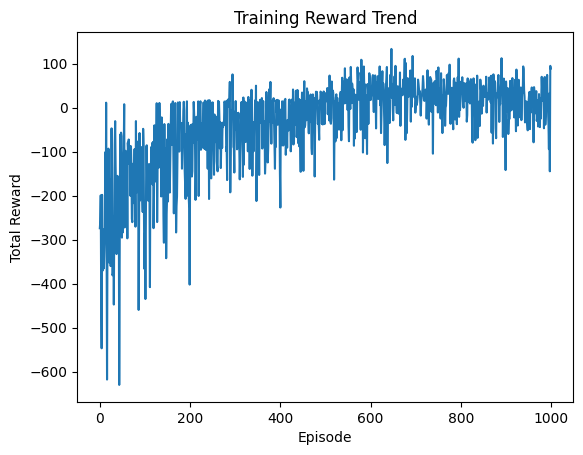

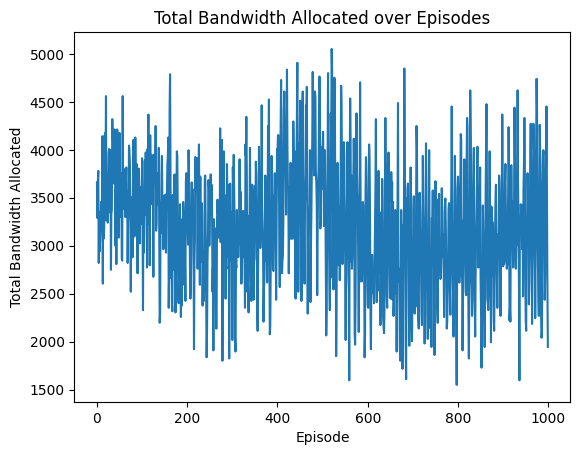

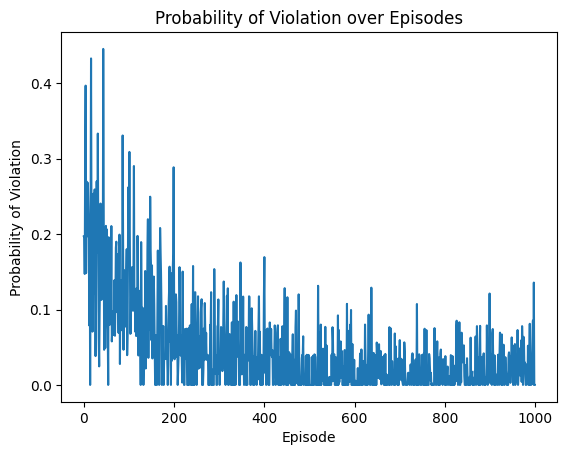

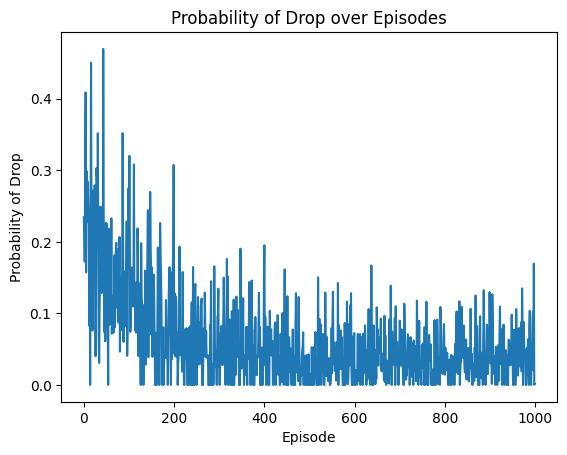

In [ ]:
# -------------------------
# Plotting Training Metrics for DQN Agent
# -------------------------

# Plot total reward per episode to visualize learning progress
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward Trend")
plt.grid(True)
plt.show()

# Plot total bandwidth allocated per episode to analyze resource usage
plt.plot(bandwidth_history)
plt.xlabel("Episode")
plt.ylabel("Total Bandwidth Allocated")
plt.title("Total Bandwidth Allocated over Episodes")
plt.grid(True)
plt.show()

# Plot average probability of queue violation per episode
plt.plot(p_violation_history)
plt.xlabel("Episode")
plt.ylabel("Probability of Violation")
plt.title("Probability of Violation over Episodes")
plt.grid(True)
plt.show()

# Plot average probability of packet drop per episode
plt.plot(p_drop_history)
plt.xlabel("Episode")
plt.ylabel("Probability of Drop")
plt.title("Probability of Drop over Episodes")
plt.grid(True)
plt.show()